# ScientISST MOVE: Getting Started with LTBio
Please cite:
_Saraiva et al., ScientISST MOVE: Activity-annotated Multimodal Biosignals acquired from multiple Wearable Devices, Scientific Data (2023)_

## A. Download Dataset

In [ ]:
import wget, zipfile, os

# Download dataset in LTBio format
url = 'https://zenodo.org/record/7940439/files/biosignal.zip?download=1'
filename = wget.download(url)  # into to the current directory

# Decompress zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('biosignal.zip')

# Delete zip file
os.remove(filename)

## B. Install LTBio

In [ ]:
# Create a virtual environment
!python -m venv env  # comment this if already created

# Install LTBio
!pip install ltbio  # comment this if already installed

## 1. Load and Explore a Biosignal
Let's use subject XXXX as an example. Consider we will need only the ECGs for this project.

In [2]:
from ltbio.biosignals.modalities import ECG
code = 'F408'
ecg = ECG.load(f'biosignal/{code}/ecg.biosignal')
ecg

Name: Chest-Abdomen ECG Double-View
Type: ECG
Location: BodyLocation.CHEST
Number of Channels: 2
Channels: dry, gel, 
Useful Duration: 0:31:13.400000
Source: ScientISST Sense
Events:
- baseline: [01 Jan, 00:00:01; 01 Jan, 00:00:39]
- lift: [01 Jan, 00:03:10; 01 Jan, 00:04:15]
- greetings: [01 Jan, 00:04:49; 01 Jan, 00:05:29]
- gesticulate: [01 Jan, 00:05:59; 01 Jan, 00:07:40]
- walk_before: [01 Jan, 00:08:20; 01 Jan, 00:10:31]
- run: [01 Jan, 00:13:37; 01 Jan, 00:39:08]
- walk_after: [01 Jan, 00:39:08; 01 Jan, 00:46:52]

Above we can see a textual description of the biosignal. From this we can gather that it was acquired with a ScientISST Sense device, that it has 2 channels, with 38 minutes of simultaneous recording on both, and that 7 events were annotated on it.

We can also get information about the subject conditions:

In [3]:
ecg.patient_conditions

(COVID-19 (Infection by SARS-CoV-2): Diagnosed 0.5 years ago.,)

We can see the subject had COVID approximately half a year ago.

But enough about metadata... Let's get a quick sneak-peak of the ECG signals:

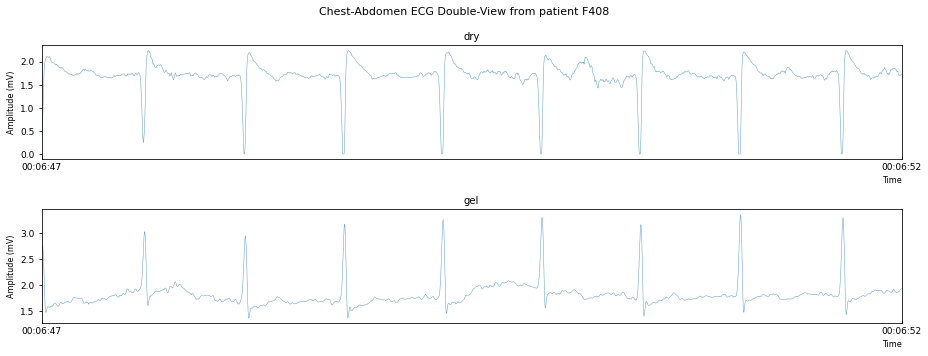

In [4]:
ecg.preview.plot()

When using `preview`, you're asking for a 5-second window right in the middle of the time series. This is helpful to quickly get a glimpse of the acquisition. We can notice that the "dry" channel is upside down, so let's invert it:

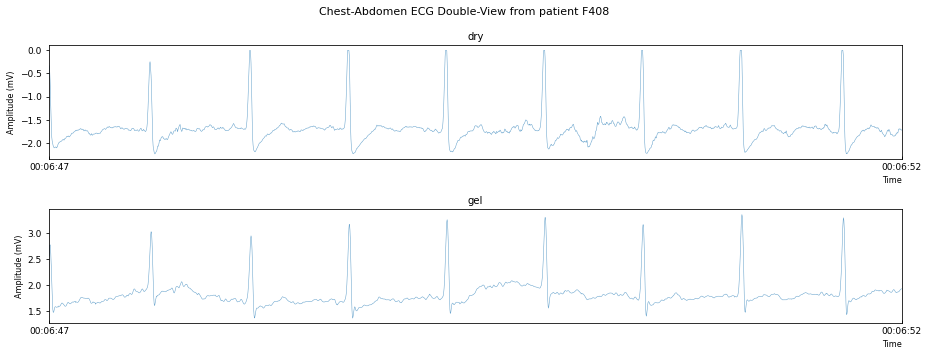

In [5]:
ecg.invert('dry')
ecg.preview.plot()

## 2. Index a Biosignal
Awsome! Let's see the ECG when the subject was lifting a chair. Recall the events annotated and their names:

In [6]:
ecg.events

(baseline: [01 Jan, 00:00:01; 01 Jan, 00:00:39],
 lift: [01 Jan, 00:03:10; 01 Jan, 00:04:15],
 greetings: [01 Jan, 00:04:49; 01 Jan, 00:05:29],
 gesticulate: [01 Jan, 00:05:59; 01 Jan, 00:07:40],
 walk_before: [01 Jan, 00:08:20; 01 Jan, 00:10:31],
 run: [01 Jan, 00:13:37; 01 Jan, 00:39:08],
 walk_after: [01 Jan, 00:39:08; 01 Jan, 00:46:52])

That's right, we're using the name "lift" for that. We can simply index the Biosignal in that interval, by indexing with the string "lift":

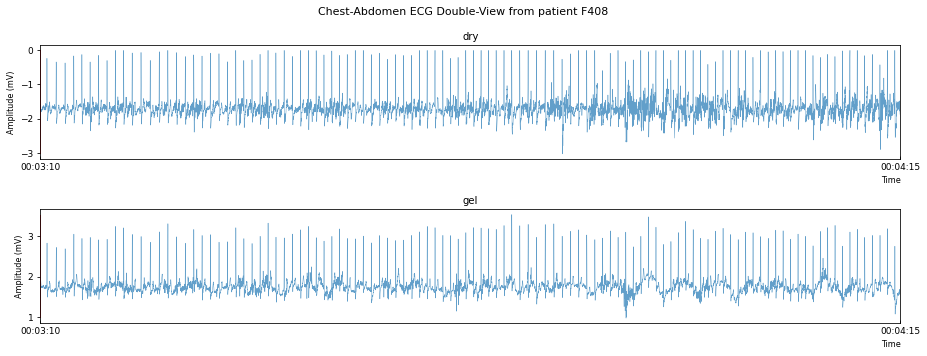

In [7]:
ecg['lift'].plot()

Look how we plotted the signals from 03:10 to 04:15, without having to memorize these timestamps.
In LTBio you can index a Biosignal with almost anything! Event names, Channel names, Datetime intervals, tuples of these, etc. Check [this article](https://ltbio.readthedocs.io/en/latest/learn/basic/ltbio101.html#indexing-a-biosignal)!
For instance, let's just get the gel electrodes when gesticulating:

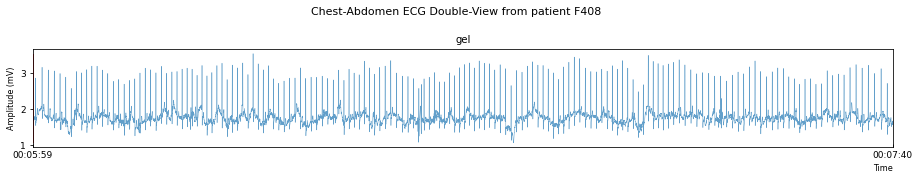

In [8]:
ecg['gel']['gesticulate'].plot()

## 3. Process a Biosignal
LTBio offers a diverse set of post-processing tools.
Let's just get the gel electrodes first to work on that signal only:

In [19]:
gel_ecg = ecg['gel']
gel_ecg

Name: Chest-Abdomen ECG Double-View
Type: ECG
Location: BodyLocation.CHEST
Number of Channels: 1
Channels: gel, 
Useful Duration: 0:31:13.400000
Source: ScientISST Sense
Events:
- baseline: [01 Jan, 00:00:01; 01 Jan, 00:00:39]
- lift: [01 Jan, 00:03:10; 01 Jan, 00:04:15]
- greetings: [01 Jan, 00:04:49; 01 Jan, 00:05:29]
- gesticulate: [01 Jan, 00:05:59; 01 Jan, 00:07:40]
- walk_before: [01 Jan, 00:08:20; 01 Jan, 00:10:31]
- run: [01 Jan, 00:13:37; 01 Jan, 00:39:08]
- walk_after: [01 Jan, 00:39:08; 01 Jan, 00:46:52]

Firstly, let's resample it to 100 Hz:

In [11]:
gel_ecg.resample(100)

Now let's filter the signal wih a simple FIR passband from 1 to 40 Hz:

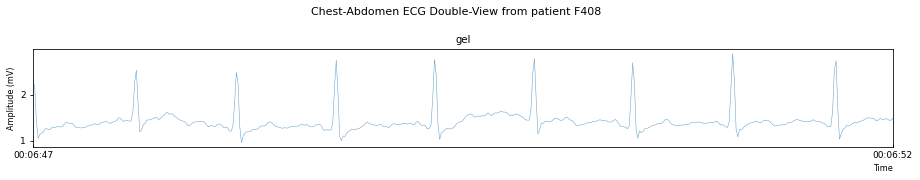

In [12]:
from ltbio.processing.filters import *

passband_filter = FrequencyDomainFilter(FrequencyResponse.FIR, BandType.BANDPASS, (1, 40), order=20)  # design the filter
gel_ecg = passband_filter(gel_ecg)  # apply the filter

gel_ecg.preview.plot()

Much better! Let's normalize it:

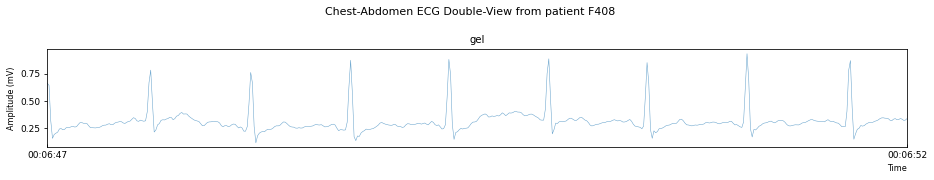

In [15]:
from ltbio.processing.formaters import Normalizer

normalizer = Normalizer(method='minmax')  # design the normalizer
gel_ecg = normalizer(gel_ecg)

gel_ecg.preview.plot()

Get to know all the LTBio features in [Learn the Basics](https://ltbio.readthedocs.io/en/latest/learn/learn.html).

## 4. Stepping out of LTBio

Biosignal objects can be saved, with all the modifications and processing done so-far, in a single line:

In [ ]:
gel_ecg.save('processed_gel_ecg.biosignal')

You can also convert it to NumPy array and keep going from there:

In [17]:
gel_ecg.to_array()

array([[0.29524778, 0.32896226, 0.31228274, ..., 0.44054139, 0.43666286,
        0.41770567]])

Or to a Pandas DataFrame:

In [18]:
gel_ecg.to_dataframe()

,gel
2000-01-01 00:00:01.739,0.295248
2000-01-01 00:00:01.749,0.328962
2000-01-01 00:00:01.759,0.312283
2000-01-01 00:00:01.769,0.321947
2000-01-01 00:00:01.779,0.360225
...,...
2000-01-01 00:39:16.279,0.386515
2000-01-01 00:39:16.289,0.418740
2000-01-01 00:39:16.299,0.440541
2000-01-01 00:39:16.309,0.436663


________
© 2023 ScientISST. All rights reserved.

Notebook offered by the [LTBio team](https://github.com/jomy-kk/LTBio).
Contact: joaomiguelsaraiva@tecnico.ulisboa.pt